In [1]:
%pylab inline
from pyspark.sql.types import *
from datetime import datetime
from pyspark.sql import Row
from time import time

Populating the interactive namespace from numpy and matplotlib


# Introduction

If you are using a transformed dataset for multiple operations, persisting the dataset in memory is a great way to improve performance by as much as 10x. Here we walk through some examples of using persistence in Spark. 

We are going to be using the Reddit comments dataset for this tutorial. More information on this dataset can be found [here](https://sites.google.com/a/insightdatascience.com/spark-lab/s3-data/reddit-comments).

# Load the data
Since the reddit dataset is so large, we'll start with just the 2009 data, which is in a json format

In [8]:
fields = [StructField("archived", BooleanType(), True),
        StructField("author", StringType(), True),
        StructField("author_flair_css_class", StringType(), True),
        StructField("body", StringType(), True),
        StructField("controversiality", LongType(), True),
        StructField("created_utc", StringType(), True),
        StructField("day", LongType(), True),
        StructField("distinguished", StringType(), True),
        StructField("downs", LongType(), True),
        StructField("edited", StringType(), True),
        StructField("gilded", LongType(), True),
        StructField("id", StringType(), True),
        StructField("link_id", StringType(), True),
        StructField("month", LongType(), True),
        StructField("name", StringType(), True),
        StructField("parent_id", StringType(), True),
        StructField("retrieved_on", LongType(), True),
        StructField("score", LongType(), True),
        StructField("score_hidden", BooleanType(), True),
        StructField("subreddit", StringType(), True),
        StructField("subreddit_id", StringType(), True),
        StructField("ups", LongType(), True),
        StructField("year", LongType(), True)]
rawDF = sqlContext.read.json("s3a://reddit-comments/2009", StructType(fields))

In [9]:
# function to convert a timestamp (created_utc field) into a dict with year, month, and day.
def cast_ts_to_ymd(row):
    row_dict = row.asDict()
    utc_dt = datetime.fromtimestamp(int(row_dict['created_utc']))
    row_dict['year'] = utc_dt.year
    row_dict['month'] = utc_dt.month
    row_dict['day'] = utc_dt.day
        
    return Row(**row_dict)

Apply the function cast_ts_to_ymd to the dataframe using the .map and .toDF transformations. We will then create a table called 'rc' which we can use for calling SparkSQL commands. If you are unfamiliar with SparkSQL, please look at the [SparkSQL](https://sites.google.com/a/insightdatascience.com/spark-lab/tutorials/6-sparksql) tutorial.

In [10]:
dateDF = rawDF.map(cast_ts_to_ymd)\
              .toDF(StructType(fields))
dateDF.registerTempTable("rc")

# Persistence
One of the most important capabilities in Spark is persisting a dataset in memory across operations. When you persist an RDD, each node stores any partitions of it that it computes in memory and reuses them in other actions on that dataset (or datasets derived from it). This allows future actions to be much faster (often by more than 10x).

You can mark an RDD to be persisted using the **persist()** method on it. The first time it is computed in an action, it will be kept in memory on the nodes. Spark’s cache is fault-tolerant – if any partition of an RDD is lost, it will automatically be recomputed using the transformations that originally created it.

In addition, each persisted RDD can be stored using a different storage level, allowing you, for example, to persist the dataset on disk, persist it in memory but as serialized Java objects (to save space), replicate it across nodes, or store it off-heap in Tachyon. These levels are set by passing a StorageLevel object (Scala, Java, Python) to persist(). 

The **cache()** method is an alias for **persist()** using the default storage level (StorageLevel.MEMORY_ONLY) which is memory only persisting. Good for quick prototyping work.

Let's persist the dataframe after we have transformed the timestamp (dateDF):

In [11]:
dateDF.persist(StorageLevel.MEMORY_AND_DISK_SER)

DataFrame[archived: boolean, author: string, author_flair_css_class: string, body: string, controversiality: bigint, created_utc: string, day: bigint, distinguished: string, downs: bigint, edited: string, gilded: bigint, id: string, link_id: string, month: bigint, name: string, parent_id: string, retrieved_on: bigint, score: bigint, score_hidden: boolean, subreddit: string, subreddit_id: string, ups: bigint, year: bigint]

Now we execute a series of queries that use the new date format. First, let's calculate the number of unique subreddits per author per month.

In [12]:
unique_subreddit_author = sqlContext.sql("""
    SELECT author, month, COUNT(DISTINCT subreddit) as cnt
    FROM rc
    GROUP BY author, month
    ORDER BY month, cnt DESC
    """)
unique_subreddit_author.registerTempTable("subreddits_per_author")

With this we can calculate the average number of unique subreddits per author for each month in 2009

In [13]:
average_subreddit_per_author = sqlContext.sql("""
    SELECT month, AVG(cnt) as avg_cnt
    FROM subreddits_per_author
    GROUP BY month
    """)

Finally run this job using the .toPandas() action and plot the result (may take a few minutes, check your 4040 status)

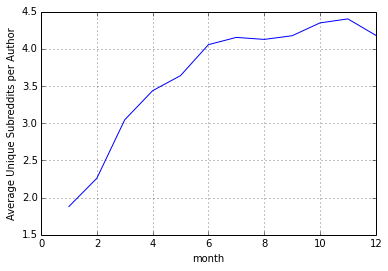

In [14]:
average_subreddit_per_author_pDF = average_subreddit_per_author.toPandas()
average_subreddit_per_author_pDF.plot(x='month', y='avg_cnt')
plt.ylabel('Average Unique Subreddits per Author')

Which subreddits have the most contributing authors in 2009?

In [15]:
unique_authors_subreddit = sqlContext.sql("""
    SELECT subreddit, COUNT(DISTINCT author) as cnt
    FROM rc
    GROUP BY subreddit
    ORDER BY cnt DESC
    """)

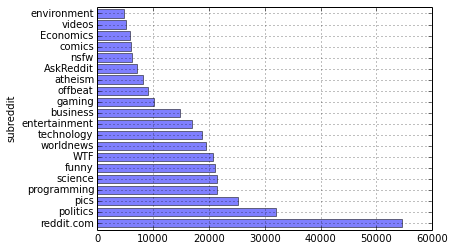

In [16]:
unique_authors_subreddit_pDF = unique_authors_subreddit.toPandas()
unique_authors_subreddit_pDF[:20].plot(x='subreddit', y='cnt', kind='barh', alpha=0.5, log=1)

# Next Steps

### Task 1: Which author contributed most to any subreddit in any given month?

** Hint: need to avoid edits such as 'deleted' **

In [ ]:
monthly = sqlContext.sql("""
    SELECT subreddit, author, month, COUNT(*) AS cnt
    FROM rc
    WHERE author NOT LIKE '[%]'
    GROUP BY subreddit, author, month
""")
monthly.registerTempTable("monthly")

# Run Task 1 and Task 2 with the persistence commented and 
# then uncommented. Why do we get a fairly significant performance boost?

#monthly.persist(StorageLevel.MEMORY_AND_DISK_SER)

contributor = sqlContext.sql("""
    SELECT monthly.month, monthly.subreddit, author, maxposts
    FROM monthly, (
        SELECT subreddit, month, MAX(cnt) AS maxposts
        FROM monthly
        GROUP BY subreddit, month
    ) AS t
    WHERE monthly.cnt = t.maxposts AND monthly.month = t.month AND monthly.subreddit = t.subreddit
    ORDER BY month, maxposts DESC
    """)
start_time = time()
contributor.collect()
time_span = time() - start_time

In [ ]:
print time_span

### Task 2: What is the average number of comments an author makes per subreddit for any given month?  
#### Hint: to optimize you should use one persist... 

In [ ]:
avg_comments_per_subreddit = sqlContext.sql("""
    SELECT month, author, AVG(cnt) as avg_comments
    FROM monthly
    GROUP BY month, author
    ORDER BY month, avg_comments DESC
""")
start_time = time()
avg_comments_per_subreddit.collect()
time_span = time() - start_time

In [ ]:
print time_span